# GCN Baseline for Product Categorization
## ML4G Course Project - Applications Research with GNNs

**Team:** Abhishek Indupally, Pranav Bhimrao Kapadne, Gaurav Suvarna

**Goal:** Analyze robustness of GNN models to edge quality (sparsification & noise)


In [1]:
from ogb.nodeproppred import PygNodePropPredDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.serialization import add_safe_globals
from torch_geometric.data import Data, Batch
from torch_geometric.data.data import DataEdgeAttr, DataTensorAttr
from torch_geometric.data.storage import GlobalStorage, NodeStorage, EdgeStorage
from torch_geometric.nn import SAGEConv, GCNConv
from torch_geometric.loader import GraphSAINTRandomWalkSampler, GraphSAINTNodeSampler
from torch_geometric.utils import subgraph, degree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import os
from tqdm import tqdm

print(" All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

 All imports successful!
PyTorch version: 2.7.1+cu118
CUDA available: True


In [2]:
# Allowlist required classes
add_safe_globals([DataEdgeAttr, DataTensorAttr, GlobalStorage, NodeStorage, EdgeStorage, Data, Batch])


In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Create directories
os.makedirs('images/edge_sensitivity', exist_ok=True)
os.makedirs('results/edge_sensitivity', exist_ok=True)
print(" Created directories: images/edge_sensitivity/, results/edge_sensitivity/")


 Created directories: images/edge_sensitivity/, results/edge_sensitivity/


## 2. LOAD BASELINE RESULTS

In [4]:
print("\n## Loading Baseline Results")

# Load MLP results
try:
    with open('mlp_500k_results.json', 'r') as f:
        mlp_results = json.load(f)
    mlp_available = True
    print(f" MLP baseline: {mlp_results['test_accuracy']:.4f}")
except:
    mlp_available = False
    print("  MLP results not found")

# Load GCN results
try:
    with open('gcn_results.json', 'r') as f:
        gcn_results = json.load(f)
    gcn_available = True
    print(f" GCN baseline: {gcn_results['test_accuracy']:.4f}")
except:
    gcn_available = False
    print("  GCN results not found")

# Load GraphSAGE results
try:
    with open('GraphSage_results.json', 'r') as f:
        graphsage_results = json.load(f)
    graphsage_available = True
    print(f" GraphSAGE baseline: {graphsage_results['test_accuracy']:.4f}")
except:
    graphsage_available = False
    print("  GraphSAGE results not found")

# Load GraphSAINT results
try:
    with open('graphsaint_random_walk_results.json', 'r') as f:
        saint_rw_results = json.load(f)
    saint_rw_available = True
    print(f" GraphSAINT-RW baseline: {saint_rw_results['test_accuracy']:.4f}")
except:
    saint_rw_available = False
    print("  GraphSAINT-RW results not found")

try:
    with open('graphsaint_node_results.json', 'r') as f:
        saint_node_results = json.load(f)
    saint_node_available = True
    print(f" GraphSAINT-Node baseline: {saint_node_results['test_accuracy']:.4f}")
except:
    saint_node_available = False
    print("  GraphSAINT-Node results not found")


## Loading Baseline Results
 MLP baseline: 0.6192
 GCN baseline: 0.7668
 GraphSAGE baseline: 0.7609
 GraphSAINT-RW baseline: 0.7715
 GraphSAINT-Node baseline: 0.7641


## 3. Load Dataset and Graph Structure

In [5]:
# Load ogbn-products
dataset = PygNodePropPredDataset(name='ogbn-products', root='./data')
data = dataset[0]

print(f"\nOriginal Dataset Statistics:")
print(f"   Nodes: {data.num_nodes:,}")
print(f"   Edges: {data.num_edges:,}")
print(f"   Features: {data.num_node_features}")
print(f"   Classes: {dataset.num_classes}")




Original Dataset Statistics:
   Nodes: 2,449,029
   Edges: 123,718,280
   Features: 100
   Classes: 47


## 3.5 Subsample for GPU Memory Constraints

**GPU Status:** 7.22 GiB free out of 11.90 GiB total

**Strategy:** Subsample to ~500K nodes to use ~5-6GB (safe buffer)

**Full dataset would require:** ~34GB (too large for available 7GB)

**Note:** This maximizes use of available GPU while maintaining stability.

In [6]:
# Subsample to 500K nodes to use available 7GB GPU memory efficiently
# You have 7.22 GiB free - this should use ~5-6GB (safe buffer)
subsample_size = 500000

# Random sample
total_nodes = data.x.shape[0]
sampled_indices = torch.randperm(total_nodes)[:subsample_size]
sampled_indices = sampled_indices.sort()[0]  # Sort for efficiency

print(f"Original dataset: {total_nodes:,} nodes")
print(f"Subsampled to: {len(sampled_indices):,} nodes")
print(f"Subsampling ratio: {100*len(sampled_indices)/total_nodes:.1f}%")
print(f"Target GPU usage: ~5-6GB out of 7.22GB available")

# Create mapping from old indices to new indices for this subsample
subsample_mapping = {}
for new_idx, old_idx in enumerate(sampled_indices):
    subsample_mapping[old_idx.item()] = new_idx

# Extract subgraph
print("\nExtracting subgraph...")
from torch_geometric.utils import subgraph as pyg_subgraph

subsampled_edge_index, _ = pyg_subgraph(
    subset=sampled_indices,
    edge_index=data.edge_index,
    relabel_nodes=True,
    num_nodes=total_nodes
)

# Update data object with subsampled data
data.x = data.x[sampled_indices]
data.y = data.y[sampled_indices]
data.edge_index = subsampled_edge_index

print(f"Edges after subsampling: {data.edge_index.shape[1]:,}")
print(f"Edge retention: {100*data.edge_index.shape[1]/123718280:.1f}%")
print("\n Subsampling complete! Dataset optimized for 7GB available GPU memory.")
print("="*60)

Original dataset: 2,449,029 nodes
Subsampled to: 500,000 nodes
Subsampling ratio: 20.4%
Target GPU usage: ~5-6GB out of 7.22GB available

Extracting subgraph...
Edges after subsampling: 5,167,660
Edge retention: 4.2%

 Subsampling complete! Dataset optimized for 7GB available GPU memory.


## 4. Load Sales Ranking Splits

In [7]:
# Load custom splits from CSV files (sales_ranking strategy)
split_dir = "data/ogbn_products/split/sales_ranking/"
train_df = pd.read_csv(split_dir + "train.csv.gz")
valid_df = pd.read_csv(split_dir + "valid.csv.gz")
test_df = pd.read_csv(split_dir + "test.csv.gz")

# Get original split indices
original_train = torch.tensor(train_df.iloc[:, 0].values, dtype=torch.long)
original_valid = torch.tensor(valid_df.iloc[:, 0].values, dtype=torch.long)
original_test = torch.tensor(test_df.iloc[:, 0].values, dtype=torch.long)

print("\nOriginal split sizes (before subsampling):")
print(f"  Train: {len(original_train):,}")
print(f"  Valid: {len(original_valid):,}")
print(f"  Test: {len(original_test):,}")

# Filter splits to only include nodes in our subsample
# Remember: sampled_indices contains the original indices that were kept
train_in_sample = torch.isin(original_train, sampled_indices)
valid_in_sample = torch.isin(original_valid, sampled_indices)
test_in_sample = torch.isin(original_test, sampled_indices)

filtered_train_original = original_train[train_in_sample]
filtered_valid_original = original_valid[valid_in_sample]
filtered_test_original = original_test[test_in_sample]

print("\nSplit sizes after subsampling:")
print(f"  Train: {len(filtered_train_original):,}")
print(f"  Valid: {len(filtered_valid_original):,}")
print(f"  Test: {len(filtered_test_original):,}")

# Map original indices to new subsampled indices
split_idx = {
    'train': torch.tensor([subsample_mapping[idx.item()] for idx in filtered_train_original]),
    'valid': torch.tensor([subsample_mapping[idx.item()] for idx in filtered_valid_original]),
    'test': torch.tensor([subsample_mapping[idx.item()] for idx in filtered_test_original])
}

print("\n Splits remapped to subsampled indices")


Original split sizes (before subsampling):
  Train: 196,614
  Valid: 39,322
  Test: 2,213,090

Split sizes after subsampling:
  Train: 40,255
  Valid: 8,078
  Test: 451,666

 Splits remapped to subsampled indices


## 5. Filter to Selected 15 Labels


In [8]:
print("\n" + "="*60)
print("FILTERING TO SELECTED LABELS")
print("="*60)

# Select specific labels: 0-15 except 4
selected_labels = set(range(16)) - {4}  # {0,1,2,3,5,6,7,8,9,10,11,12,13,14,15}
print(f"Selected labels: {sorted(selected_labels)}")

# Filter nodes by selected labels (working with already subsampled data)
label_mask = torch.tensor([label.item() in selected_labels for label in data.y])
filtered_node_indices = torch.where(label_mask)[0]

print(f"\nFiltered nodes with selected labels: {filtered_node_indices.shape[0]:,}")

# Filter splits to only include selected labels
train_mask = torch.isin(split_idx['train'], filtered_node_indices)
valid_mask = torch.isin(split_idx['valid'], filtered_node_indices)
test_mask = torch.isin(split_idx['test'], filtered_node_indices)

filtered_train_idx = split_idx['train'][train_mask]
filtered_valid_idx = split_idx['valid'][valid_mask]
filtered_test_idx = split_idx['test'][test_mask]

print("\nFinal split sizes (after label filtering):")
print(f"  Train: {len(filtered_train_idx):,}")
print(f"  Valid: {len(filtered_valid_idx):,}")
print(f"  Test: {len(filtered_test_idx):,}")



FILTERING TO SELECTED LABELS
Selected labels: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Filtered nodes with selected labels: 284,290

Final split sizes (after label filtering):
  Train: 25,513
  Valid: 5,152
  Test: 253,624


## 6. Create Subgraph with Selected Labels

**Note:** Data is already subsampled (200K nodes). Now we filter further to only selected labels.

In [9]:
# Extract features and labels for filtered nodes
X = data.x[filtered_node_indices]
y = data.y[filtered_node_indices].squeeze()

# Remap labels to 0 to num_classes-1 (important for classification)
label_map = {orig: new for new, orig in enumerate(sorted(selected_labels))}
y_mapped = torch.tensor([label_map[label.item()] for label in y])

print(f"\nNode features shape: {X.shape}")
print(f"Labels shape: {y_mapped.shape}")
print(f"Unique labels in filtered set: {torch.unique(y).tolist()}")
print(f"Remapped labels: {torch.unique(y_mapped).tolist()}")


Node features shape: torch.Size([284290, 100])
Labels shape: torch.Size([284290])
Unique labels in filtered set: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Remapped labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [10]:
# ===== EXTRACT SUBGRAPH (FAST & CLEAN) =====
print("\n" + "="*60)
print("EXTRACTING SUBGRAPH")
print("="*60)

print("Extracting subgraph with selected nodes and edges...")

# Use PyG's built-in subgraph function
remapped_edges, _ = subgraph(
    subset=filtered_node_indices,
    edge_index=data.edge_index,
    relabel_nodes=True,
    num_nodes=data.x.shape[0]
)

print(f"\n Subgraph extraction complete!")
print(f"Original edges: {data.edge_index.shape[1]:,}")
print(f"Filtered edges: {remapped_edges.shape[1]:,}")
print(f"Percentage of edges kept: {100 * remapped_edges.shape[1] / data.edge_index.shape[1]:.2f}%")

# Store original edge_index for experiments
original_edge_index = remapped_edges.clone()
original_num_edges = original_edge_index.shape[1]



EXTRACTING SUBGRAPH
Extracting subgraph with selected nodes and edges...

 Subgraph extraction complete!
Original edges: 5,167,660
Filtered edges: 2,942,500
Percentage of edges kept: 56.94%


In [11]:
# Create index mapping for remapping split indices
index_mapping = {orig_idx.item(): new_idx for new_idx, orig_idx in enumerate(filtered_node_indices)}

print(f"\n Index mapping created for {len(index_mapping):,} nodes")



 Index mapping created for 284,290 nodes


In [12]:
# Remap split indices to new filtered indices
train_idx = torch.tensor([index_mapping[idx.item()] for idx in filtered_train_idx])
valid_idx = torch.tensor([index_mapping[idx.item()] for idx in filtered_valid_idx])
test_idx = torch.tensor([index_mapping[idx.item()] for idx in filtered_test_idx])

print("\nRemapped split indices (for subgraph):")
print(f"  Train: {train_idx.shape[0]:,}")
print(f"  Valid: {valid_idx.shape[0]:,}")
print(f"  Test: {test_idx.shape[0]:,}")

# Store dataset info
num_features = X.shape[1]
num_classes = len(selected_labels)

print(f"\n Dataset ready for edge sensitivity analysis!")
print(f"   Nodes: {X.shape[0]:,}")
print(f"   Edges: {remapped_edges.shape[1]:,}")
print(f"   Features: {num_features}")
print(f"   Classes: {num_classes}")


Remapped split indices (for subgraph):
  Train: 25,513
  Valid: 5,152
  Test: 253,624

 Dataset ready for edge sensitivity analysis!
   Nodes: 284,290
   Edges: 2,942,500
   Features: 100
   Classes: 15


## MODEL ARCHITECTURES

In [13]:
print("\n" + "="*60)
print("DEFINING MODEL ARCHITECTURES")
print("="*60)

class MLP(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout
        
    def forward(self, x, edge_index=None):
        # MLP doesn't use edge_index, but we keep it for consistent API
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)
        return x

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Second GCN layer
        x = self.conv2(x, edge_index)
        
        return x

class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        # First GraphSage layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Second GraphSage layer
        x = self.conv2(x, edge_index)
        
        return x

print(" Model architectures defined (MLP, GCN, GraphSAGE)")

# Model parameters (matching training)
hidden_channels = 128



DEFINING MODEL ARCHITECTURES
 Model architectures defined (MLP, GCN, GraphSAGE)


In [14]:
# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")

# Move data to device
X = X.to(device)
y_mapped = y_mapped.to(device)
remapped_edges = remapped_edges.to(device)
original_edge_index = original_edge_index.to(device)
train_idx = train_idx.to(device)
valid_idx = valid_idx.to(device)
test_idx = test_idx.to(device)

print(" Data moved to device")


Device: cuda
 Data moved to device


## EDGE MODIFICATION FUNCTIONS

In [15]:
print("\n" + "="*60)
print("EDGE MODIFICATION FUNCTIONS")
print("="*60)

def remove_edges_random(edge_index, removal_rate, seed=42):
    """
    Randomly remove a percentage of edges.
    
    Args:
        edge_index: Original edge index tensor
        removal_rate: Fraction of edges to remove (0.0 to 1.0)
        seed: Random seed for reproducibility
    
    Returns:
        Modified edge_index with edges removed
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    num_edges = edge_index.shape[1]
    num_to_keep = int(num_edges * (1 - removal_rate))
    
    # Randomly select edges to keep
    perm = torch.randperm(num_edges)
    keep_indices = perm[:num_to_keep]
    
    modified_edge_index = edge_index[:, keep_indices]
    
    return modified_edge_index

def add_random_edges(edge_index, num_nodes, addition_rate, seed=42):
    """
    Add random edges to the graph.
    
    Args:
        edge_index: Original edge index tensor
        num_nodes: Total number of nodes
        addition_rate: Fraction of original edges to add as noise
        seed: Random seed
    
    Returns:
        Modified edge_index with random edges added
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    num_original = edge_index.shape[1]
    num_to_add = int(num_original * addition_rate)
    
    # Generate random edges
    random_src = torch.randint(0, num_nodes, (num_to_add,))
    random_dst = torch.randint(0, num_nodes, (num_to_add,))
    
    # Remove self-loops from random edges
    mask = random_src != random_dst
    random_src = random_src[mask]
    random_dst = random_dst[mask]
    
    random_edges = torch.stack([random_src, random_dst])
    
    # Combine original and random edges
    modified_edge_index = torch.cat([edge_index, random_edges], dim=1)
    
    return modified_edge_index

print(" Edge modification functions defined")



EDGE MODIFICATION FUNCTIONS
 Edge modification functions defined


## EVALUATION FUNCTION

In [16]:
@torch.no_grad()
def evaluate_model(model, x, edge_index, test_mask, y_test):
    """Evaluate model on modified graph."""
    model.eval()
    
    # Forward pass
    if isinstance(model, MLP):
        out = model(x)
    else:
        out = model(x, edge_index)
    
    # Compute accuracy
    pred = out[test_mask].argmax(dim=1)
    accuracy = (pred == y_test).float().mean().item()
    
    return accuracy

print(" Evaluation function defined")

 Evaluation function defined


## LOAD TRAINED MODELS

In [ ]:
print("\n" + "="*60)
print("LOADING TRAINED MODELS")
print("="*60)

models = {}

# Load MLP
if mlp_available and os.path.exists('models/mlp_best.pt'):
    try:
        mlp_model = MLP(num_features, hidden_channels, num_classes, dropout=0.5)
        mlp_model.load_state_dict(torch.load('models/mlp_best.pt'))
        mlp_model = mlp_model.to(device)
        mlp_model.eval()
        models['MLP'] = mlp_model
        print(" Loaded MLP model")
    except Exception as e:
        print(f"  Could not load MLP model: {e}")

# Load GCN
if gcn_available and os.path.exists('models/gcn_best.pt'):
    try:
        gcn_model = GCN(num_features, hidden_channels, num_classes, dropout=0.5)
        gcn_model.load_state_dict(torch.load('models/gcn_best.pt'))
        gcn_model = gcn_model.to(device)
        gcn_model.eval()
        models['GCN'] = gcn_model
        print(" Loaded GCN model")
    except Exception as e:
        print(f"  Could not load GCN model: {e}")

# Load GraphSAGE
if graphsage_available and os.path.exists('models/graphsage_best.pt'):
    try:
        sage_model = GraphSAGE(num_features, hidden_channels, num_classes, dropout=0.5)
        sage_model.load_state_dict(torch.load('models/graphsage_best.pt'))
        sage_model = sage_model.to(device)
        sage_model.eval()
        models['GraphSAGE'] = sage_model
        print(" Loaded GraphSAGE model")
    except Exception as e:
        print(f"  Could not load GraphSAGE model: {e}")

# Load GraphSAINT-RW
if saint_rw_available and os.path.exists('models/graphsaint_rw_best.pt'):
    try:
        saint_rw_model = GraphSAGE(num_features, hidden_channels, num_classes, dropout=0.5)
        saint_rw_model.load_state_dict(torch.load('models/graphsaint_rw_best.pt'))
        saint_rw_model = saint_rw_model.to(device)
        saint_rw_model.eval()
        models['GraphSAINT-RW'] = saint_rw_model
        print(" Loaded GraphSAINT-RW model")
    except Exception as e:
        print(f"  Could not load GraphSAINT-RW model: {e}")

# Load GraphSAINT-Node
if saint_node_available and os.path.exists('models/graphsaint_node_best.pt'):
    try:
        saint_node_model = GraphSAGE(num_features, hidden_channels, num_classes, dropout=0.5)
        saint_node_model.load_state_dict(torch.load('models/graphsaint_node_best.pt'))
        saint_node_model = saint_node_model.to(device)
        saint_node_model.eval()
        models['GraphSAINT-Node'] = saint_node_model
        print(" Loaded GraphSAINT-Node model")
    except Exception as e:
        print(f"  Could not load GraphSAINT-Node model: {e}")

if len(models) == 0:
    print("\nERROR: No models loaded!")
    print("Please save model checkpoints first:")
    print("  1. In each training notebook, add after training:")
    print("     torch.save(model.state_dict(), 'models/<model_name>_best.pt')")
    print("  2. Run the training notebooks to create the checkpoints")
    print("  3. Then run this edge sensitivity analysis")
    raise RuntimeError("No trained models available")

print(f"\n Successfully loaded {len(models)} models for testing")



LOADING TRAINED MODELS
  Could not load MLP model: Error(s) in loading state_dict for MLP:
	Missing key(s) in state_dict: "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias". 
	Unexpected key(s) in state_dict: "lin1.weight", "lin1.bias", "lin2.weight", "lin2.bias", "lin3.weight", "lin3.bias". 
 Loaded GCN model
 Loaded GraphSAGE model
 Loaded GraphSAINT-RW model
 Loaded GraphSAINT-Node model

 Successfully loaded 4 models for testing


## EXPERIMENT 1: EDGE SPARSIFICATION

In [18]:
print("\n" + "="*70)
print("EXPERIMENT 1: EDGE SPARSIFICATION")
print("="*70)
print("Testing robustness to edge removal (simulating incomplete graphs)")

# Define removal rates to test
removal_rates = [0.0, 0.1, 0.25, 0.5, 0.75, 0.9]
print(f"\nRemoval rates: {[f'{r*100:.0f}%' for r in removal_rates]}")

# Store results
sparsification_results = {model_name: [] for model_name in models.keys()}

# Run experiments
for removal_rate in removal_rates:
    print(f"\n{'='*70}")
    print(f"Testing with {removal_rate*100:.0f}% edges removed")
    print(f"{'='*70}")
    
    if removal_rate == 0.0:
        # Use original graph
        modified_edge_index = original_edge_index
        print(f"Using original graph: {modified_edge_index.shape[1]:,} edges")
    else:
        # Remove edges
        modified_edge_index = remove_edges_random(
            original_edge_index.cpu(),  # Move to CPU for modification
            removal_rate,
            seed=42
        ).to(device)  # Move back to device
        print(f"  Removed {original_num_edges - modified_edge_index.shape[1]:,} edges ({removal_rate*100:.0f}%)")
        print(f"  Remaining: {modified_edge_index.shape[1]:,} edges")
    
    # Test each model
    for model_name, model in models.items():
        accuracy = evaluate_model(
            model,
            X,
            modified_edge_index,
            test_idx,
            y_mapped[test_idx]
        )
        sparsification_results[model_name].append(accuracy)
        print(f"  {model_name:20s}: {accuracy:.4f}")

# Save sparsification results
sparsification_df = pd.DataFrame(sparsification_results, index=[f"{r*100:.0f}%" for r in removal_rates])
sparsification_df.index.name = 'Edges Removed'

print("\n" + "="*70)
print("EDGE SPARSIFICATION RESULTS")
print("="*70)
print(sparsification_df.to_string())

# Save to CSV
sparsification_df.to_csv('results/edge_sensitivity/edge_sparsification_results.csv')
print("\n Saved results to results/edge_sensitivity/edge_sparsification_results.csv")




EXPERIMENT 1: EDGE SPARSIFICATION
Testing robustness to edge removal (simulating incomplete graphs)

Removal rates: ['0%', '10%', '25%', '50%', '75%', '90%']

Testing with 0% edges removed
Using original graph: 2,942,500 edges
  GCN                 : 0.7668
  GraphSAGE           : 0.7606
  GraphSAINT-RW       : 0.7715
  GraphSAINT-Node     : 0.7641

Testing with 10% edges removed
  Removed 294,250 edges (10%)
  Remaining: 2,648,250 edges
  GCN                 : 0.7621
  GraphSAGE           : 0.7548
  GraphSAINT-RW       : 0.7654
  GraphSAINT-Node     : 0.7607

Testing with 25% edges removed
  Removed 735,625 edges (25%)
  Remaining: 2,206,875 edges
  GCN                 : 0.7532
  GraphSAGE           : 0.7443
  GraphSAINT-RW       : 0.7544
  GraphSAINT-Node     : 0.7556

Testing with 50% edges removed
  Removed 1,471,250 edges (50%)
  Remaining: 1,471,250 edges
  GCN                 : 0.7295
  GraphSAGE           : 0.7154
  GraphSAINT-RW       : 0.7259
  GraphSAINT-Node     : 0.7404



## EXPERIMENT 2: EDGE NOISE INJECTION

In [19]:
print("\n" + "="*70)
print("EXPERIMENT 2: EDGE NOISE INJECTION")
print("="*70)
print("Testing robustness to random edge addition (simulating noisy graphs)")

# Define addition rates to test
addition_rates = [0.0, 0.1, 0.25, 0.5, 1.0]
print(f"\nAddition rates: {[f'{r*100:.0f}%' for r in addition_rates]}")

# Store results
noise_results = {model_name: [] for model_name in models.keys()}

# Run experiments
for addition_rate in addition_rates:
    print(f"\n{'='*70}")
    print(f"Testing with {addition_rate*100:.0f}% random edges added")
    print(f"{'='*70}")
    
    if addition_rate == 0.0:
        # Use original graph
        modified_edge_index = original_edge_index
        print(f"Using original graph: {modified_edge_index.shape[1]:,} edges")
    else:
        # Add random edges
        modified_edge_index = add_random_edges(
            original_edge_index.cpu(),  # Move to CPU for modification
            X.shape[0],
            addition_rate,
            seed=42
        ).to(device)  # Move back to device
        print(f"  Added {modified_edge_index.shape[1] - original_num_edges:,} random edges ({addition_rate*100:.0f}% of original)")
        print(f"  Total edges: {modified_edge_index.shape[1]:,}")
    
    # Test each model
    for model_name, model in models.items():
        accuracy = evaluate_model(
            model,
            X,
            modified_edge_index,
            test_idx,
            y_mapped[test_idx]
        )
        noise_results[model_name].append(accuracy)
        print(f"  {model_name:20s}: {accuracy:.4f}")

# Save noise injection results
noise_df = pd.DataFrame(noise_results, index=[f"+{r*100:.0f}%" for r in addition_rates])
noise_df.index.name = 'Random Edges Added'

print("\n" + "="*70)
print("EDGE NOISE INJECTION RESULTS")
print("="*70)
print(noise_df.to_string())

# Save to CSV
noise_df.to_csv('results/edge_sensitivity/edge_noise_results.csv')
print("\n Saved results to results/edge_sensitivity/edge_noise_results.csv")




EXPERIMENT 2: EDGE NOISE INJECTION
Testing robustness to random edge addition (simulating noisy graphs)

Addition rates: ['0%', '10%', '25%', '50%', '100%']

Testing with 0% random edges added
Using original graph: 2,942,500 edges
  GCN                 : 0.7668
  GraphSAGE           : 0.7606
  GraphSAINT-RW       : 0.7715
  GraphSAINT-Node     : 0.7641

Testing with 10% random edges added
  Added 294,248 random edges (10% of original)
  Total edges: 3,236,748
  GCN                 : 0.6873
  GraphSAGE           : 0.6905
  GraphSAINT-RW       : 0.7015
  GraphSAINT-Node     : 0.7009

Testing with 25% random edges added
  Added 735,624 random edges (25% of original)
  Total edges: 3,678,124
  GCN                 : 0.6277
  GraphSAGE           : 0.6462
  GraphSAINT-RW       : 0.6516
  GraphSAINT-Node     : 0.6589

Testing with 50% random edges added
  Added 1,471,245 random edges (50% of original)
  Total edges: 4,413,745
  GCN                 : 0.5750
  GraphSAGE           : 0.6159
  Gra

## DEGRADATION ANALYSIS

In [ ]:
print("\n" + "="*70)
print("DEGRADATION ANALYSIS")
print("="*70)

# Calculate accuracy drop from baseline
print("\nAccuracy Degradation (vs Original Graph):")

print("\n1. Edge Sparsification (90% edges removed):")
for model_name in models.keys():
    baseline = sparsification_results[model_name][0]
    worst = sparsification_results[model_name][-1]  # 90% removed
    degradation = baseline - worst
    degradation_pct = (degradation / baseline) * 100
    print(f"  {model_name:20s}: {degradation:.4f} ({degradation_pct:.1f}% drop)")

print("\n2. Edge Noise Injection (100% random edges added):")
for model_name in models.keys():
    baseline = noise_results[model_name][0]
    worst = noise_results[model_name][-1]  # 100% added
    degradation = baseline - worst
    degradation_pct = (degradation / baseline) * 100
    print(f"  {model_name:20s}: {degradation:.4f} ({degradation_pct:.1f}% drop)")




DEGRADATION ANALYSIS

📉 Accuracy Degradation (vs Original Graph):

1. Edge Sparsification (90% edges removed):
  GCN                 : 0.1505 (19.6% drop)
  GraphSAGE           : 0.2031 (26.7% drop)
  GraphSAINT-RW       : 0.2065 (26.8% drop)
  GraphSAINT-Node     : 0.0991 (13.0% drop)

2. Edge Noise Injection (100% random edges added):
  GCN                 : 0.2589 (33.8% drop)
  GraphSAGE           : 0.1761 (23.2% drop)
  GraphSAINT-RW       : 0.2072 (26.9% drop)
  GraphSAINT-Node     : 0.1716 (22.5% drop)


## VISUALIZATIONS

In [21]:
print("\n" + "="*70)
print("CREATING VISUALIZATIONS")
print("="*70)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
color_map = {name: colors[i] for i, name in enumerate(models.keys())}



CREATING VISUALIZATIONS


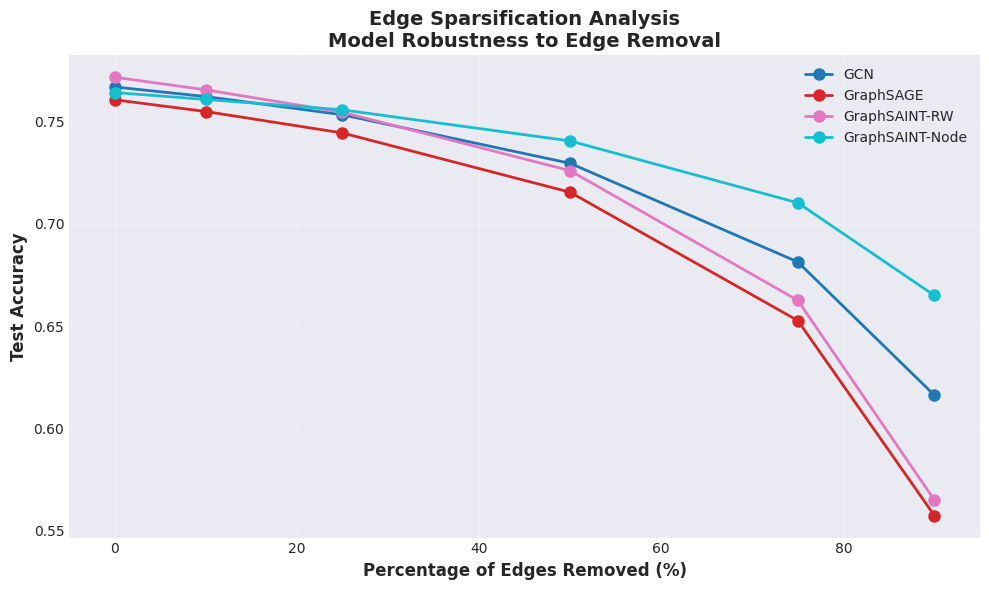

 Saved: edge_sparsification_curves.png


In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

for model_name in models.keys():
    ax.plot(
        [r * 100 for r in removal_rates],
        sparsification_results[model_name],
        marker='o',
        linewidth=2,
        markersize=8,
        label=model_name,
        color=color_map[model_name]
    )

ax.set_xlabel('Percentage of Edges Removed (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Edge Sparsification Analysis\nModel Robustness to Edge Removal', fontsize=14, fontweight='bold')
ax.legend(loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_xlim(-5, 95)

plt.tight_layout()
plt.savefig('images/edge_sensitivity/edge_sparsification_curves.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(" Saved: edge_sparsification_curves.png")


## Visualization 2: Edge Noise Injection Curves

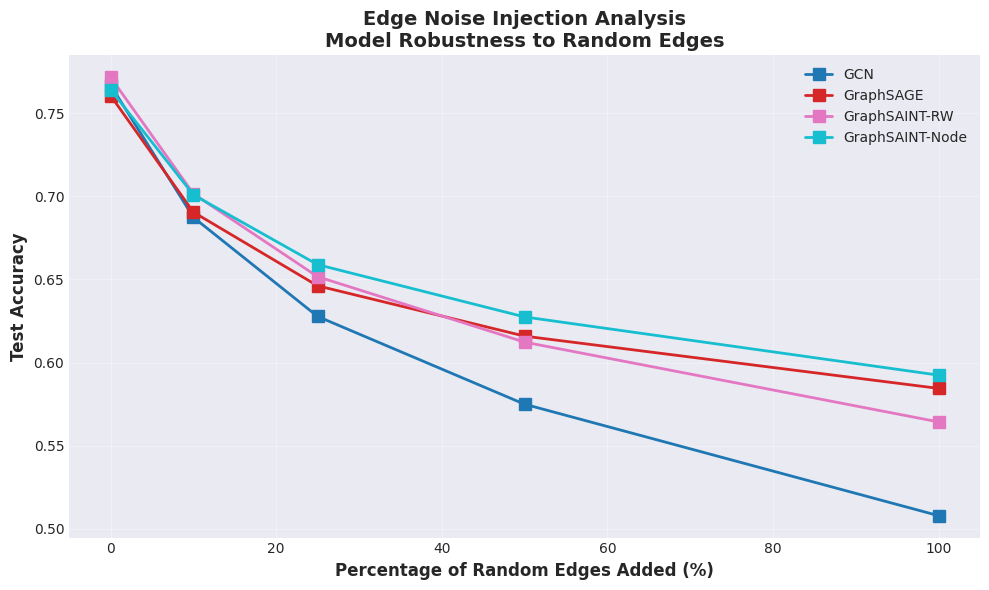

 Saved: edge_noise_curves.png


In [23]:
fig, ax = plt.subplots(figsize=(10, 6))

for model_name in models.keys():
    ax.plot(
        [r * 100 for r in addition_rates],
        noise_results[model_name],
        marker='s',
        linewidth=2,
        markersize=8,
        label=model_name,
        color=color_map[model_name]
    )

ax.set_xlabel('Percentage of Random Edges Added (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Edge Noise Injection Analysis\nModel Robustness to Random Edges', fontsize=14, fontweight='bold')
ax.legend(loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/edge_sensitivity/edge_noise_curves.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(" Saved: edge_noise_curves.png")


## Visualization 3: Combined Comparison

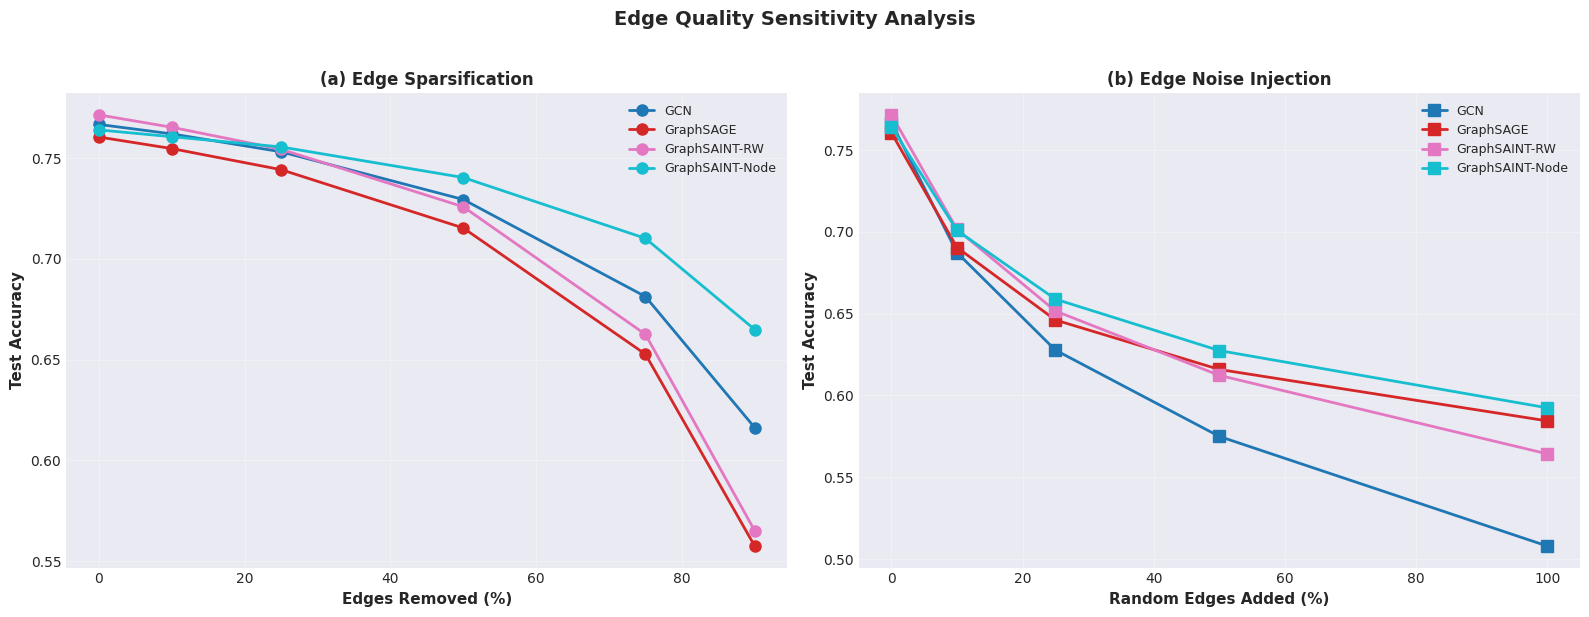

 Saved: combined_sensitivity_analysis.png


In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Sparsification
for model_name in models.keys():
    ax1.plot(
        [r * 100 for r in removal_rates],
        sparsification_results[model_name],
        marker='o',
        linewidth=2,
        markersize=8,
        label=model_name,
        color=color_map[model_name]
    )

ax1.set_xlabel('Edges Removed (%)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Test Accuracy', fontsize=11, fontweight='bold')
ax1.set_title('(a) Edge Sparsification', fontsize=12, fontweight='bold')
ax1.legend(loc='best', framealpha=0.9, fontsize=9)
ax1.grid(True, alpha=0.3)

# Right plot: Noise
for model_name in models.keys():
    ax2.plot(
        [r * 100 for r in addition_rates],
        noise_results[model_name],
        marker='s',
        linewidth=2,
        markersize=8,
        label=model_name,
        color=color_map[model_name]
    )

ax2.set_xlabel('Random Edges Added (%)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Test Accuracy', fontsize=11, fontweight='bold')
ax2.set_title('(b) Edge Noise Injection', fontsize=12, fontweight='bold')
ax2.legend(loc='best', framealpha=0.9, fontsize=9)
ax2.grid(True, alpha=0.3)

plt.suptitle('Edge Quality Sensitivity Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('images/edge_sensitivity/combined_sensitivity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(" Saved: combined_sensitivity_analysis.png")


## Visualization 4: Degradation Heatmap

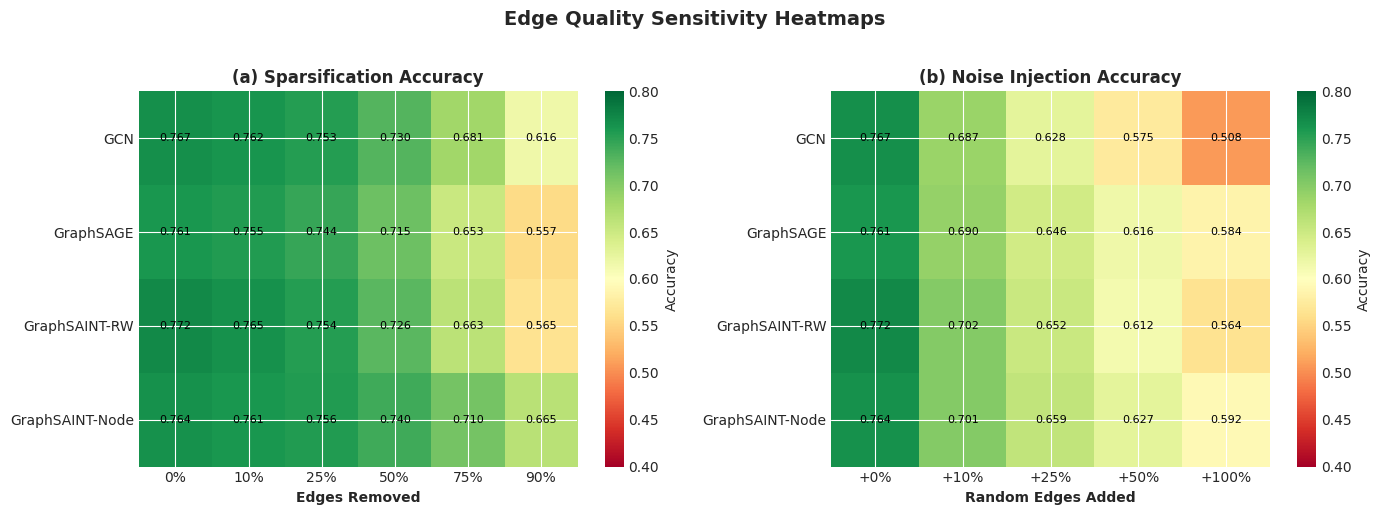

 Saved: sensitivity_heatmaps.png


In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Prepare data for heatmaps
sparsification_matrix = np.array([sparsification_results[m] for m in models.keys()])
noise_matrix = np.array([noise_results[m] for m in models.keys()])

# Sparsification heatmap
im1 = ax1.imshow(sparsification_matrix, cmap='RdYlGn', aspect='auto', vmin=0.4, vmax=0.8)
ax1.set_xticks(range(len(removal_rates)))
ax1.set_xticklabels([f'{r*100:.0f}%' for r in removal_rates])
ax1.set_yticks(range(len(models)))
ax1.set_yticklabels(list(models.keys()))
ax1.set_xlabel('Edges Removed', fontweight='bold')
ax1.set_title('(a) Sparsification Accuracy', fontweight='bold')

# Add text annotations
for i in range(len(models)):
    for j in range(len(removal_rates)):
        text = ax1.text(j, i, f'{sparsification_matrix[i, j]:.3f}',
                       ha="center", va="center", color="black", fontsize=8)

# Noise heatmap
im2 = ax2.imshow(noise_matrix, cmap='RdYlGn', aspect='auto', vmin=0.4, vmax=0.8)
ax2.set_xticks(range(len(addition_rates)))
ax2.set_xticklabels([f'+{r*100:.0f}%' for r in addition_rates])
ax2.set_yticks(range(len(models)))
ax2.set_yticklabels(list(models.keys()))
ax2.set_xlabel('Random Edges Added', fontweight='bold')
ax2.set_title('(b) Noise Injection Accuracy', fontweight='bold')

# Add text annotations
for i in range(len(models)):
    for j in range(len(addition_rates)):
        text = ax2.text(j, i, f'{noise_matrix[i, j]:.3f}',
                       ha="center", va="center", color="black", fontsize=8)

# Add colorbars
fig.colorbar(im1, ax=ax1, label='Accuracy')
fig.colorbar(im2, ax=ax2, label='Accuracy')

plt.suptitle('Edge Quality Sensitivity Heatmaps', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('images/edge_sensitivity/sensitivity_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(" Saved: sensitivity_heatmaps.png")


# SAVE SUMMARY RESULTS

In [26]:
summary_results = {
    'experiment': 'Edge Sensitivity Analysis',
    'models_tested': list(models.keys()),
    'sparsification': {
        'removal_rates': removal_rates,
        'results': sparsification_results
    },
    'noise_injection': {
        'addition_rates': addition_rates,
        'results': noise_results
    },
    'degradation_analysis': {
        'sparsification_90pct': {
            model: {
                'baseline': sparsification_results[model][0],
                'degraded': sparsification_results[model][-1],
                'drop': sparsification_results[model][0] - sparsification_results[model][-1]
            }
            for model in models.keys()
        },
        'noise_100pct': {
            model: {
                'baseline': noise_results[model][0],
                'degraded': noise_results[model][-1],
                'drop': noise_results[model][0] - noise_results[model][-1]
            }
            for model in models.keys()
        }
    }
}

with open('results/edge_sensitivity/summary_results.json', 'w') as f:
    json.dump(summary_results, f, indent=2)

print("\n Saved: summary_results.json")
print("\n" + "="*70)
print(" EDGE SENSITIVITY ANALYSIS COMPLETE!")
print("="*70)

print("\nKey Findings:")

print("\n1. Most Robust Model (Sparsification):")
final_spars = {m: sparsification_results[m][-1] for m in models.keys()}
best_spars = max(final_spars, key=final_spars.get)
print(f"   {best_spars}: {final_spars[best_spars]:.4f} at 90% edge removal")

print("\n2. Most Robust Model (Noise Injection):")
final_noise = {m: noise_results[m][-1] for m in models.keys()}
best_noise = max(final_noise, key=final_noise.get)
print(f"   {best_noise}: {final_noise[best_noise]:.4f} with 100% random edges")

print("\n3. Baseline Performance (Original Graph):")
for model_name in models.keys():
    baseline_acc = sparsification_results[model_name][0]
    print(f"   {model_name}: {baseline_acc:.4f}")

print("\n Generated Files:")
print("\n  Results:")
print("    - results/edge_sensitivity/edge_sparsification_results.csv")
print("    - results/edge_sensitivity/edge_noise_results.csv")
print("    - results/edge_sensitivity/summary_results.json")
print("\n  Visualizations:")
print("    - images/edge_sensitivity/edge_sparsification_curves.png")
print("    - images/edge_sensitivity/edge_noise_curves.png")
print("    - images/edge_sensitivity/combined_sensitivity_analysis.png")
print("    - images/edge_sensitivity/sensitivity_heatmaps.png")

print("\n" + "="*70)
print("Next Step: Cold-Start Resilience Analysis")
print("="*70)



 Saved: summary_results.json

 EDGE SENSITIVITY ANALYSIS COMPLETE!

Key Findings:

1. Most Robust Model (Sparsification):
   GraphSAINT-Node: 0.6650 at 90% edge removal

2. Most Robust Model (Noise Injection):
   GraphSAINT-Node: 0.5924 with 100% random edges

3. Baseline Performance (Original Graph):
   GCN: 0.7668
   GraphSAGE: 0.7606
   GraphSAINT-RW: 0.7715
   GraphSAINT-Node: 0.7641

 Generated Files:

  Results:
    - results/edge_sensitivity/edge_sparsification_results.csv
    - results/edge_sensitivity/edge_noise_results.csv
    - results/edge_sensitivity/summary_results.json

  Visualizations:
    - images/edge_sensitivity/edge_sparsification_curves.png
    - images/edge_sensitivity/edge_noise_curves.png
    - images/edge_sensitivity/combined_sensitivity_analysis.png
    - images/edge_sensitivity/sensitivity_heatmaps.png

Next Step: Cold-Start Resilience Analysis
